In [ ]:
# Need lyapy from Allison
!pip install git+https://github.com/allisony/lyapy
!pip install emcee
!pip install corner
!pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/allisony/lyapy to /tmp/pip-req-build-me9chjb2
  Running command git clone --filter=blob:none --quiet https://github.com/allisony/lyapy /tmp/pip-req-build-me9chjb2
  Resolved https://github.com/allisony/lyapy to commit 159707c6aa8090f070b20ee24d6fe6799b5a52c4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lyapy-allisony: filename=lyapy_allisony-0.0.1-py3-none-any.whl size=55817 sha256=409628f4598090de73ce92c73d632b546054a9545eb64fb4b19bdbd4a11482d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-6qh1mpmy/wheels/68/d7/b6/c4dcadbf0c7b7426daccbab90db2c63696ce14adc8602bbc77
Successfully built lyapy-allisony
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# **Finding the relationship between flare frequency and peak irradiance**

##**Upload the NOAA data**

We begin by uploading the peak irradiance of all the recorded flares from 2010 to 2020 provided by Space Weather Data Portal. The datafile has four columns: Date and time of the flare peak, the peak irradiance, the flare class, and the date and time of the end of the flare. 

In [ ]:
listoflares = pd.read_csv('sci_xrsf-l2-flsum_g15_s20100331_e20200304_v1-0-0.nc.csv')     # Import data using pandas library

display(listoflares)       # Display the dataframe of the list of flares

,Time [ISO8601],Flare Class,Peak Flux [W/m2]
0,2011-01-14T00:06:00Z,B3.1,3.102040e-07
1,2011-01-14T02:19:00Z,B3.0,3.094000e-07
2,2011-01-14T03:26:00Z,C2.3,2.353960e-06
3,2011-01-14T13:07:00Z,C1.4,1.447450e-06
4,2011-01-14T15:51:00Z,B2.9,2.955390e-07
...,...,...,...
18828,2018-02-08T19:49:00Z,B2.5,2.591880e-07
18829,2018-02-08T20:33:00Z,B8.8,8.830330e-07
18830,2018-02-08T21:14:00Z,B2.0,2.013070e-07
18831,2018-02-08T21:30:00Z,B4.6,4.685210e-07


## **Plot the flare frequency vs peak irradiance**

Once again, we are trying to answer this question: given the peak irradiance of a flare, how often do flares with a similar peak irradiance occur? So let's start by grouping flares with a similar peak irradiance. 

We can do this by using the function `histogram` from the `numpy` library. A histogram splits the data up into different intervals called "**bins**": for example, flares with an irradiance from 0 up to 0.00001 $W/m^2$, from 0.00001 up to 0.00002, etc. The histogram will tell us the number of flares in each "bin" over 10 years 


In [ ]:
n_bins =  30

bin_edge = np.geomspace(1e-8, 9e-3, n_bins+1) # Define bin edges logarithmically spaced apart

# Split peak irradiances into x number of bins
# the variable hist contains the total # of flares in each bin
# bin_edges contains the edge irradiance values of each of the bins
hist, bin_edges = np.histogram(listoflares['Peak Flux [W/m2]'], bins=bin_edge)

# Let's also calculate some properties of the histogram bins which we will use later

# Calculate bin widths from the bin edges
bin_widths = np.diff(bin_edges)

# Calculate bin centers from bin edges 
bin_centers = bin_edges[:-1] + np.diff(bin_edges)/2


Before we plot, there are two more adjustments we have to make. 

1. First, we are interested in how frequently these flares occur *per year*, not over 10 years. So we have to take the histogram data and divide by 10. 

2. To understand the second adjustment, suppose we used a much wider bin that went all the way from 0.00001 up to 0.00009. Certainly, there would be more flares per year that fall into this new range. But that wouldn't really be because the flares were occurring more often. To counteract this effect, we will also divide the number of flares in the bin by the *width* of the bin.

In the end, we will have divided by "10 years" and also by the width of the irradiance bins, which have units of W/m^2. This means the units on our y-axis are "number of flares per year, per (W/m^2)". We will just call this the "Flare Frequency".  


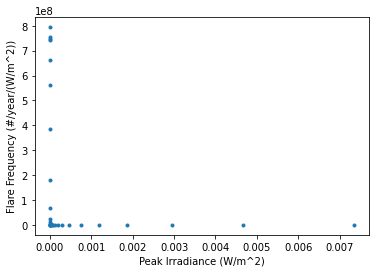

In [ ]:
# Two adjustments to the data

#Calculate for a single year instead of 10 years
num_flares_per_year = hist/10

# Calculate the number of flares over 10 years per bin width
num_flares_per_year_per_binwidth = num_flares_per_year/bin_widths

# Plot
plt.plot(bin_centers, num_flares_per_year_per_binwidth, '.')
plt.xlabel('Peak Irradiance (W/m^2)')
plt.ylabel('Flare Frequency (#/year/(W/m^2))')

plt.show()

## **Log Plotting and Cleaning up the data**

Because the shape is so sharply curved and because the y-data covers such a large range, it will be easier to visualize the data using a log scale. Use the code cell below to graph the data on a log-log scale instead.



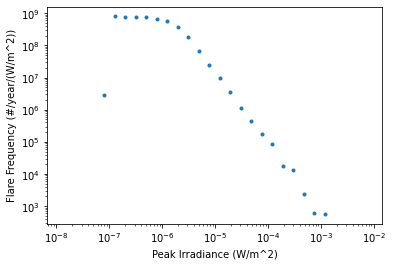

In [ ]:
import matplotlib.pyplot as plt

## Plot hist on log-log scale
plt.plot(bin_centers, num_flares_per_year_per_binwidth, '.')
plt.xlabel('Peak Irradiance (W/m^2)')
plt.ylabel('Flare Frequency (#/year/(W/m^2))')
plt.xscale('log')
plt.yscale('log')
plt.show()

On a log scale, the distribution looks linear, indicating that it follows a power law. To fit these data, we will use the standard mathematical method of actually *taking the log* of the data first, and then fitting it to a line (lines are easy to fit!)

But there is a small problem to deal with first.

Notice that in the graphs above, some of the data points may be zero. If we display the data directly we see the same thing. 



In [ ]:
display(num_flares_per_year_per_binwidth)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.77440523e+06, 7.94023909e+08, 7.53024425e+08, 7.40903053e+08,
       7.46939979e+08, 6.63252904e+08, 5.60120913e+08, 3.83748191e+08,
       1.80336040e+08, 6.61236311e+07, 2.50288299e+07, 9.97075857e+06,
       3.51376515e+06, 1.16712702e+06, 4.52636390e+05, 1.78393274e+05,
       8.33271262e+04, 1.75869447e+04, 1.33627823e+04, 2.35028021e+03,
       5.95257512e+02, 5.65355203e+02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

Since we plan to take a log of the data before we fit it, zero values pose a problem because the $log(0)$ is undefined. Let's run some code to remove these zeros.

In [ ]:
import numpy as np

# List of the indices where # of flares per bin width is zero
index_of_zeros = np.where(num_flares_per_year_per_binwidth == 0)

# Delete the elements in bin_centers and num_of_flares_per_binwidth based on the
#  list of indices where um_of_flares_per_binwidth has a zero value
num_flares_per_year_per_binwidth = np.delete(num_flares_per_year_per_binwidth, index_of_zeros)
bin_centers = np.delete(bin_centers, index_of_zeros)
bin_edges = np.delete(bin_edges, index_of_zeros[0]+1)

display(num_flares_per_year_per_binwidth)

array([2.77440523e+06, 7.94023909e+08, 7.53024425e+08, 7.40903053e+08,
       7.46939979e+08, 6.63252904e+08, 5.60120913e+08, 3.83748191e+08,
       1.80336040e+08, 6.61236311e+07, 2.50288299e+07, 9.97075857e+06,
       3.51376515e+06, 1.16712702e+06, 4.52636390e+05, 1.78393274e+05,
       8.33271262e+04, 1.75869447e+04, 1.33627823e+04, 2.35028021e+03,
       5.95257512e+02, 5.65355203e+02])

Since these data no longer have any zeros in it, it will be safe to take the log before fitting a line, which is how we will ultimately determine the power law relationship.


## **Find the power law**

We now can find a power law by fitting the linear region shown on the log-log plot. You will need to use the `linregress` function in the `scipy.stats` library. [Here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) is a link to the reference library on the `linregress` function.

The `linregress` function takes two parameters as inputs: `x` and `y` and calclates a best fit line to those data. The function has five outputs: 

> 1) Slope: The slope of the best fit line

> 2) Intercept: The y-intercept of the best fit line

> 3) R-value: We won't use it in this class, but this is the "correlation coefficient", which measures how close the data are to falling on a perfect line. 

> 4) p-value: We won't use this either, but technically speaking, this is the two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic. 

> 5) Standard error: Standard error of the estimated slope.

To find the power-law relationship, we will also need to fit the line to the **log of the data** rather than to the raw data itself.

In [ ]:
import numpy as np
import scipy.stats as stats

## Define the x and y data for the linear regression
x =  np.log(bin_centers[11:29])   
y =  np.log(num_flares_per_year_per_binwidth[11:29])  

PI2F_slope, PI2F_intercept, PI2F_r_value, PI2F_p_value, PI2F_std_err = stats.linregress(x, y)

display(PI2F_slope, PI2F_intercept, PI2F_r_value, PI2F_p_value, PI2F_std_err)

-2.2201218407067107

-9.005943036013377

-0.9958467755951684

1.1157430656217704e-10

0.06765802716064227

Now, let's calcuate the best fit curve for the original data by "undoing" the log:

In [ ]:
import numpy as np

## Calculate the best fit line using the slope and intercept given by the linear 
## regression function above.   
PI2F_best_fit_line = np.exp(PI2F_slope*np.log(bin_centers[11:29])+PI2F_intercept)


 Plot the `num_flares_per_year_per_binwidth` data versus `bin_centers` along with the best fit curve to visualize the fit. We suggest plotting in log-log scale, which will make both the data and the best-fit curve appear linear.
 

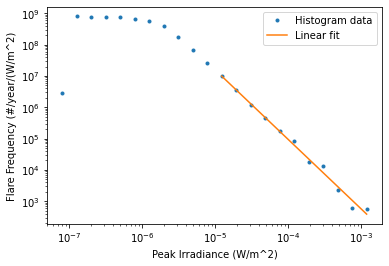

In [ ]:
import matplotlib.pyplot as plt

## Plot the bin_centers versus flare_per_year_per_binwidth data and the best fit  
## line on the same graph to visualize the fit. Note, that we need to take the  
## exponential of the linear fit in order to translate it to a power law fit. 

plt.plot(bin_centers, num_flares_per_year_per_binwidth, '.')
plt.plot(bin_centers[11:29], PI2F_best_fit_line)#note the bin range here
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Peak Irradiance (W/m^2)')
plt.ylabel('Flare Frequency (#/year/(W/m^2)')
plt.legend(['Histogram data', 'Linear fit'])

plt.show()

## Confirm power law using MLE

### Using equations 2 and 3 from D'Huys+ 2016
https://link.springer.com/article/10.1007/s11207-016-0910-5#Sec15

In [ ]:
def calculate_alpha_and_sigma_with_mle(x, x_min):
  n = len(x)
  alpha = 1 + n / np.sum(np.log(x/x_min))
  sigma = ((alpha - 1) / np.sqrt(n)) + (1/n)
  return alpha, sigma

In [ ]:
data = listoflares['Peak Flux [W/m2]']
x_min = 3.5e-6
indices = np.where(data > x_min)
alpha_peaks, sigma_peaks = calculate_alpha_and_sigma_with_mle(data.iloc[indices], x_min)
print(alpha_peaks, '±', sigma_peaks)

2.1644835204925457 ± 0.018779022516479858


### Using `powerlaw` package

In [ ]:
import powerlaw
data = listoflares['Peak Flux [W/m2]'].values
results = powerlaw.Fit(data)
print(results.power_law.alpha, '±', results.power_law.sigma)
print(results.power_law.xmin)

Calculating best minimal value for power law fit
2.1643466904333772 ± 0.014984275823281814
2.43371e-06


### Compare the methods

In [ ]:
print('Linear fit:', PI2F_slope, '±', PI2F_std_err)
print("D'Huys+ 2016 equations:", alpha_peaks, '±', sigma_peaks)
print('`powerlaw` package', results.power_law.alpha, '±', results.power_law.sigma)

Linear fit: -2.2201218407067107 ± 0.06765802716064227
D'Huys+ 2016 equations: 2.1644835204925457 ± 0.018779022516479858
`powerlaw` package 2.1643466904333772 ± 0.014984275823281814


## **Upload the C-PhLARE data and plot**


In [ ]:
import pandas as pd

CPhLARE_data = pd.read_csv('CPhLARE_data.csv')     # Import data using pandas library

display(CPhLARE_data)       # Display the dataframe of the classes data


,Peak Irr,Energy
0,0.000327,9.814290e+29
1,0.000002,2.510000e+27
2,0.000504,1.150000e+29
3,0.000005,3.900000e+27
4,0.000009,5.680000e+27
...,...,...
207,0.000010,8.371430e+27
208,0.000011,2.557140e+28
209,0.000014,1.324290e+28
210,0.000014,7.957140e+28


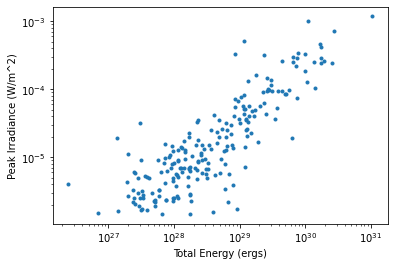

In [ ]:
import matplotlib.pyplot as plt

# Plot the data collected by C-PhLARE as peak irradiance versus total energy
#plt.plot(CPhLARE_data_old.iloc[:,1],CPhLARE_data_old.iloc[:,0], 'rv')
plt.plot(CPhLARE_data.iloc[:,1],CPhLARE_data.iloc[:,0], '.')
# Plot on a log-log scale
plt.ylabel('Peak Irradiance (W/m^2)')
plt.xlabel('Total Energy (ergs)')
plt.xscale('log')
plt.yscale('log')

plt.show()


## **Compute the flare frequency from the given peak irradiance**

So these data gives us a relationship between flare energy and peak irradiance. We want a relationship between flare energy and flare frequency, so we'll use the expression that predicts flare frequency from peak irradiance (recall, "flare frequency" is roughly how often a similar flare is expected to occur per year). We can do this by computing the flare frequencies from the peak irradiance.



In [ ]:
import numpy as np

## Calculate the flare frequency using the expression from last week 
Ifreq = np.exp(PI2F_slope*np.log(CPhLARE_data.iloc[:,0]) + PI2F_intercept)

**A technical note:** When we said "flare frequency" previously, we meant "how frequently is there a flare with similar peak irradiance?" To take this into account, we divided by the irradiance "bin width", which gave us units of 
 $ #/year/(W/m^2)$. 
 

# **Convert from flare frequency/year/(W/m^2) to flare frequency/year/erg**

Now, we want to ask "how frequently is there a flare with similar *total energy*?" In that context, what we're calling "flare frequency" should have  units of $ #/year /erg $. 

We'll convert between the two with a little bit of calculus, you can read the details [here](https://drive.google.com/file/d/1DE9NWDFI8O1DvxblxaHGpoledt8Tp_ij/view?usp=sharing). 

To find $dI/dE$ we need to know the relationship of $I(E)$. However, $E$, the independent variable, has more uncertainty in it than $I$ the dependent variable. However, traditional linear fitting algotithms assume that all the "error" is in the dependent variable, so we are going to find the relationship of $E(I)$ and then invert it.  

So, we need to do a bit of math:

We want to find the following relationship

$y = \beta x^{\alpha}$,


but we use a linear regression to calculate

$\log(x) = m\log(y) + b$.

First, we need to find the "inverted" slope and intercept,

$\log(y) = \frac{1}{m}\log(x) - \frac{b}{m}$,

then we take the exponential of both sides,

$y = e^{-\frac{b}{m}}x^{\frac{1}{m}}$.

Thus,

$\alpha = {\frac{1}{m}}$ and $\beta = e^{-\frac{b}{m}}.$

We can also calculate the propogated uncertainties in $\alpha$ and $\beta$:

$\partial \alpha = -\frac{1}{m^2}\partial m$ and  $\partial \beta = \sqrt{\left(\frac{be^{-\frac{b}{m}}}{m^2}\partial m\right)^2 + \left(-\frac{e^{-\frac{b}{m}}}{m}\partial b\right)^2 }.$

*Side note: We additionally, tested four different fitting techniques a standard linear regression and three robust linear regression algorithms: (1) Huber regression, (2) RANSAC Regression, and (3) Theil Sen Regression. All of which are described [here](https://machinelearningmastery.com/robust-regression-for-machine-learning-in-python/). We can then compare the four regression algorithms based on mean performance of each method, and more usefully, use tools like a box and whisker plot to compare the distribution of scores across the repeated cross-validation folds as well as their best fit lines. The robust regressions did not significantly outperform the linear regression so we chose to use a simple linear regression and did not give significantly different slopes nor intercepts. This analysis is shown in the "Supplemental Code" section at the end of this notebook.* 

In [ ]:
lr_EIslope, lr_EIintercept, lr_EIr_value, lr_EIp_value, lr_EIstd_err = stats.linregress(np.log(CPhLARE_data.iloc[:,0]), np.log(CPhLARE_data.iloc[:,1]))

# Invert to find relationship of I(E)
lr_IEalpha = 1/lr_EIslope
lr_IEstd_err = (1/(lr_EIslope)**2)*(lr_EIstd_err) # Error propogation to determine SE of alphaIE # AAY+JPM: we removed the minus in "-1" that was here b/c this can only be positive since it _should_ be the square root of the squares so no negative numbers can survive
lr_IEbeta = np.exp(-lr_EIintercept/lr_EIslope)

print("Linear regression on energy versus peak; alpha:", lr_EIslope, " +- ", lr_EIstd_err)
print("Linear regression on peak versus energy; alpha:", lr_IEalpha, " +- ", lr_IEstd_err)

Linear regression on energy versus peak; alpha: 1.0276489077024429  +-  0.04444624921535426
Linear regression on peak versus energy; alpha: 0.9730949865316758  +-  0.04208676908760155


Now, we can use these values to calculate the "per erg" frequency from the "per W/m^2" frequency and propogate the errors through. There are a lot of equations going on here, so to make it easier to read, they are also written up in Latex [this](https://drive.google.com/file/d/1vUZcKSOIcS0prZ1Ty74kjxJcEJVchWxR/view?usp=sharing) PDF.


In [ ]:
# Calculate the "per erg" frequency from the "per W/m^2" frequency

#This fit gives us I(E) as a power law
#Calculate dI/dE from this power law with basic calc
lr_IEderivs = (lr_IEbeta*lr_IEalpha)*CPhLARE_data.iloc[:,1]**(lr_IEalpha-1)
# Error propogation to determine SE of dI/dE
#lr_IEderivs_err = (lr_IEbeta*CPhLARE_data.iloc[:,1]**(lr_IEalpha-1))*((lr_IEalpha-1)*lr_IEalpha*np.log(CPhLARE_data.iloc[:,1])+2*lr_IEalpha-1)*lr_IEstd_err
# The above isn't consistent with what's written in the PDF equation 7. Below is consistent: 
#lr_IEderivs_err = (lr_IEbeta*CPhLARE_data.iloc[:,1]**(lr_IEalpha-1))*(lr_IEalpha*np.log(CPhLARE_data.iloc[:,1]) + 1)*lr_IEstd_err
lr_IEderivs_err = (lr_IEbeta*CPhLARE_data.iloc[:,1]**(lr_IEalpha-1)) * (CPhLARE_data.iloc[:,1]**(lr_IEalpha-1)) * (np.log(CPhLARE_data.iloc[:,1]))*lr_IEstd_err # 2023-01-09: AAY+JPM rederived this again after noticing that the values were _larger_ than lr_IEderivs, which didn't seem like it could be right. This calculation does have smaller values as expected.

#Calculate frequencies from energy at each point using the first fit (above)
Ifreq = np.exp(PI2F_slope*np.log(CPhLARE_data.iloc[:,0]) + PI2F_intercept)
# Error propogation to determine SE of Ifreq
#Ifreq_err = np.log(CPhLARE_data.iloc[:,0])*PI2F_slope*np.exp(PI2F_slope-1)*PI2F_std_err
# AAY+JPM: The above seems to be an error in taking the derivative in the exponential. Below is what we think is right but we note that the impact on alpha was only at the third decimal point. 
Ifreq_err = np.sqrt(np.log(CPhLARE_data.iloc[:,0])**2 * Ifreq**2 *PI2F_std_err**2)


#Apply the chain rule: dn/dE = (dn/dI)*(dI/dE)
Efreq = Ifreq*lr_IEderivs
# Error propogation to determine SE of Efreq
Efreq_err = np.sqrt((lr_IEderivs_err*Ifreq)**2 + (Ifreq_err*lr_IEderivs)**2)


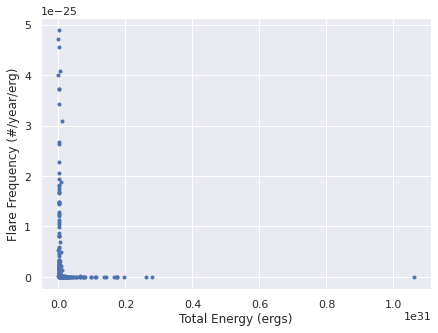

In [ ]:
## Plot the flare frequency versus the total flare energy of the class data on
## a linear scale. The flare frequency should be the y data and the total flare
## energy should be the x data.

plt.plot(CPhLARE_data.iloc[:,1], Efreq, '.')
plt.xlabel('Total Energy (ergs)')
plt.ylabel('Flare Frequency (#/year/erg)')

plt.show()

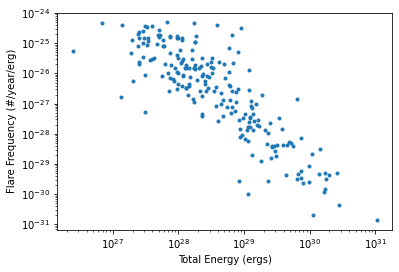

In [ ]:
## Plot the flare frequency versus the total flare energy of the class data on
## a log-log scale. The flare frequency should be the y data and the total flare
## energy should be the x data.

plt.plot(CPhLARE_data.iloc[:,1], Efreq, '.')
plt.xlabel('Total Energy (ergs)')
plt.ylabel('Flare Frequency (#/year/erg)')
plt.xscale('log')
plt.yscale('log')

plt.show()

# **Find the power law relationship between total energy and flare frequency**

And now, the ultimate goal: what is the power law relationship between flare frequency and flare energy? In particular, what is the parameter "alpha?"

We use a weighted least squares regression with the weights being the standard errors of `Efreq` that we calcualted above.

Like before, $E$, the independent variable, has more uncertainty in it than $f_E$ (`Efreq`) the dependent variable. However, traditional linear fitting algotithms assume that all the "error" is in the dependent variable, so we are going to find the relationship of $E(f_E)$ and then invert it.  

*Side note: We, again, compared the four different fitting techniques a standard linear regression and three robust linear regression algorithms: (1) Huber regression, (2) RANSAC Regression, and (3) Theil Sen Regression for both $f_{E,l}$ and $f_{E,pl}$. Again, the robust regressions did not significantly outperform the linear regression so we chose to use a simple linear regression and did not give significantly different slopes nor intercepts. This analysis is shown in the "Supplemental Code" section at the end of this notebook.* 

In [ ]:
from numpy import arange
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor
import statsmodels.api as sm
from matplotlib import pyplot

# reformat dataset
X = np.log(Efreq)      ## the x data for the linear regression is the frequency/year/erg
y = np.log(CPhLARE_data.iloc[:,1])    # the y data for the linear regression is the energies ("E")
w = Efreq_err/Efreq   # Need to divide by Efreq since we are taking the linear regession of the logs

X = X.to_numpy()
y = y.to_numpy()

X = np.reshape(X, (-1,1))

In [ ]:
model = LinearRegression()

reg = model.fit(X, y,  sample_weight=w)

slope = reg.coef_
intercept = reg.intercept_

# invert the function to find the relationship of Efreq(E) 
# calculate alpha and beta  
alpha = 1/slope
beta = np.exp(-intercept/slope)

print("Linear regression slope:", slope)
print("Linear regression alpha:", alpha)

Linear regression slope: [-0.4561857]
Linear regression alpha: [-2.19208974]


Is there really no way of determining the standard error of the slope with `sklean`??? Amazing! Well, let's plug this data into the linear regression algorithm in R and see what we get:

```
Call:
lm(formula = log(Energy) ~ log(Efreq), data = df, weights = eEfreq_err)

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-5.7935 -0.9904  0.0150  1.0369  5.2923 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 38.84215    1.13810   34.13   <2e-16 ***
log(Efreq)  -0.44304    0.01864  -23.77   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.663 on 210 degrees of freedom
Multiple R-squared:  0.7291,	Adjusted R-squared:  0.7278 
F-statistic: 565.2 on 1 and 210 DF,  p-value: < 2.2e-16

```



In [ ]:
# R reports the standard error of log(Efreq) as: 
log_Eqfreq_slope = -0.44304 
error_log_Efreq_slope = 0.01864
log_Eqfreq_intercept = 38.84215
error_log_Efreq_intercept = 1.13810

# Invert to find relationship to get Efreq(E)
alpha_linear = 1/log_Eqfreq_slope
std_err = (1/(log_Eqfreq_slope)**2)*(error_log_Efreq_slope) # Error propogation to determine SE of alphaIE 
beta = np.exp(-log_Eqfreq_intercept/log_Eqfreq_slope)
std_err_b = np.sqrt(((-1/log_Eqfreq_slope)*np.exp(-log_Eqfreq_intercept/log_Eqfreq_slope)*error_log_Efreq_intercept)**2 + (log_Eqfreq_intercept*np.exp(-log_Eqfreq_intercept/log_Eqfreq_slope)*(error_log_Efreq_slope/log_Eqfreq_slope**2))**2)


print("Alpha:", alpha_linear, " +- ", std_err)
print("Beta:", beta, " +- ", std_err_b)

Alpha: -2.2571325388226797  +-  0.09496422563121784
Beta: 1.1896356800815311e+38  +-  5.34738662911121e+38


Great, R gives us the same value for the slope! Whew! We can calculate alpha, the standard error of alpha, and the intercept based on the R data:

$\alpha = -2.257 \pm 0.095$

$\beta = 1.190 \pm 5.347 * 10^{38}$ 

Now, let's plot!

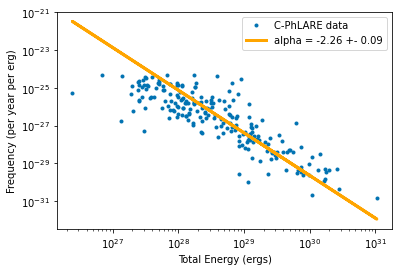

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-colorblind')

## Best fit line
best_fit_line = beta*(CPhLARE_data.iloc[:,1]**alpha_linear)

fig, ax = plt.subplots()

## Plot the data with the best fit line on a log-log scale and inlcude a legend
ax.plot(CPhLARE_data.iloc[:,1], Efreq, '.')
ax.plot(CPhLARE_data.iloc[:,1], best_fit_line, color='orange', linewidth=3)

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Frequency (per year per erg)')
plt.xlabel('Total Energy (ergs)')

## You need to fill in the value for alpha (Hint: "alpha" is the slope you found
## in the linregress function)
plt.legend(['C-PhLARE data', 'alpha = -2.26 +- 0.09']) 

plt.show()

You can uncomment the code below to save the data.

In [ ]:
## save data

#data = [CPhLARE_data.iloc[:,1], Efreq]
#headers = ["Energy", "Frequency"]
#df = pd. concat(data, axis=1, keys=headers)

#display(df)

##from google.colab import files

#df.to_csv('data.csv', encoding = 'utf-8-sig') 
#files.download('data.csv')

# Use MLE to find power law relationship between total energy and flare frequency

D'Huys et al. (2016; https://link.springer.com/article/10.1007/s11207-016-0910-5#Sec15) looked at exactly this problem for solar physics and found that maximum likelihood estimation (MLE) is far and away the best method for finding the value of $\alpha$. 
1. Equations 2 and 3 in that paper capture the method. 
2. The `powerlaw` package encapsulates the code to do it and makes it possible to do the fit in a single line of code. 
3. We can also do a generic MLE with all the Bayesian magic and get uncertainty from doing an MCMC, thanks to Allison's code. 

So, let's try all 3 methods and ensure they agree with each other. 

### Using equations 2 and 3 from D'Huys+ 2016

In [ ]:
def calculate_alpha_and_sigma_with_mle(x, x_min):
  n = len(x)
  alpha = 1 + n / np.sum(np.log(x/x_min))
  sigma = ((alpha - 1) / np.sqrt(n)) + (1/n)
  return alpha, sigma

In [ ]:
data = CPhLARE_data['Energy']
x_min = 8.36e28
indices = np.where(data > x_min)
alpha, sigma = calculate_alpha_and_sigma_with_mle(data.iloc[indices], x_min)
print(alpha, '±', sigma)

1.7474032619187616 ± 0.10197120801950582


### Using powerlaw package

In [ ]:
import powerlaw
data = CPhLARE_data['Energy'].values
results = powerlaw.Fit(data)
print('alpha = ', results.power_law.alpha, '±', results.power_law.sigma)
print('x_min = ', results.power_law.xmin)

Calculating best minimal value for power law fit
alpha =  1.7577838627787445 ± 0.08869189262633945
x_min =  8.36e+28


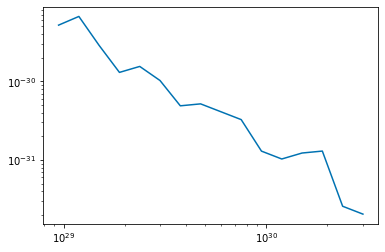

In [ ]:
results.plot_pdf()

### Using Allison's code to do a generic MLE inside an MCMC run. 

In [ ]:
nwalkers = 200
nsteps = 3000
burnin = 500
np.random.seed(1281)
start_uniform = True
nruns = 1
fresh_start = True 
perform_error = False

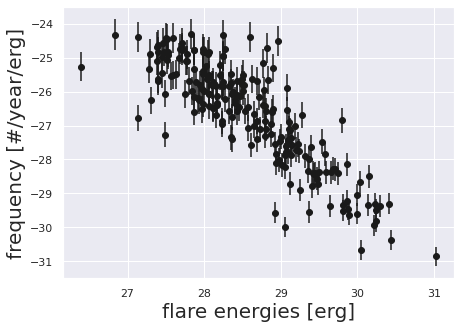

In [ ]:
import scipy.optimize as op
from lyapy import lyapy
from lyapy.fitting import *
from lyapy import lya_plot

x = np.log10(CPhLARE_data['Energy'].values)
y = np.log10(Efreq)
yerr = Efreq_err/Efreq / np.log(10)

# must be a list - this gives the option of fitting multiple lines at once (you probably won't be doing that though)
x_to_fit = [x]
y_to_fit = [y]
yerr_to_fit = [yerr]

plt.errorbar(x,y,yerr=yerr,fmt='ko',label='Input Data')
plt.xlabel('flare energies [erg]',fontsize=20)
plt.ylabel('frequency [#/year/erg]',fontsize=20)

def my_model(x_to_fit, resolution, parameters, variables,lnlike=True,convolve=False):
    x = x_to_fit[0]
    m, b = parameters
    y_model = m * x + b
    return [y_model] # must be a list

variables_order = ['m', 'b']


variables = make_parameter_dictionary(variables_order)

p = 'm'
variables[p]['texname'] = 'm'
variables[p]['value'] = -3
variables[p]['vary'] = True 
variables[p]['scale'] = 0.5
variables[p]['min'] = -3
variables[p]['max'] = -1
variables[p]['my model'] = my_model
variables[p]['Gaussian prior'] = False
variables[p]['prior mean'] = -3
variables[p]['prior stddev'] = 0.6


p = 'b'
variables[p]['texname'] = 'b'
variables[p]['value'] = 38.08
variables[p]['vary'] = True
variables[p]['scale'] = 0.05
variables[p]['min'] = 0
variables[p]['max'] = 100
# ([-2, 1.2e38])


perform_variable_check(variables)

In [ ]:
if not perform_error:
    sampler, pos0 = setup_sampler(x_to_fit, y_to_fit, yerr_to_fit, None,
                              nwalkers, variables, variables_order, my_model, None, start_uniform)

Varying:  ['m', 'b']
m -3
b 38.08


In [ ]:
# Perform MCMC
if not perform_error:
    sampler_chain = perform_mcmc(sampler, pos0, nsteps, nruns=nruns, fresh_start = fresh_start)
else:
    sampler_chain = get_sampler_chain()


ndim = 0
for p in variables:
    if variables[p]['vary']:
        ndim += 1

samples = sampler_chain[:, burnin:, :].reshape((-1, ndim))


best, variables = extract_best_fit_parameters(samples, variables, variables_order)

Run #1
Fresh start
Done.
Time to complete MCMC #1: 472.2 seconds
Saving option 1
m [-1.6909255153093374, -1.6614219211928136, -1.6309874852512278, -1.6003221609847529, -1.5711477181443774]
b [18.156910126031523, 18.99524992742494, 19.878170462768193, 20.752843454989293, 21.598437443157906]


Mean acceptance fraction: 0.708
should be between 0.25 and 0.5


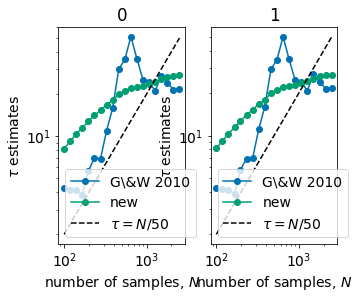

In [ ]:
if not perform_error:
    print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
    print("should be between 0.25 and 0.5")


make_convergence_plot(sampler_chain, ndim, burnin)

Quantiles:
[(0.025, -1.6909255153093374), (0.975, -1.5711477181443774)]
Quantiles:
[(0.025, 18.156910126031523), (0.975, 21.598437443157906)]


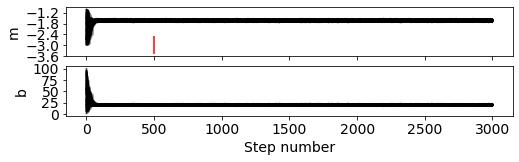

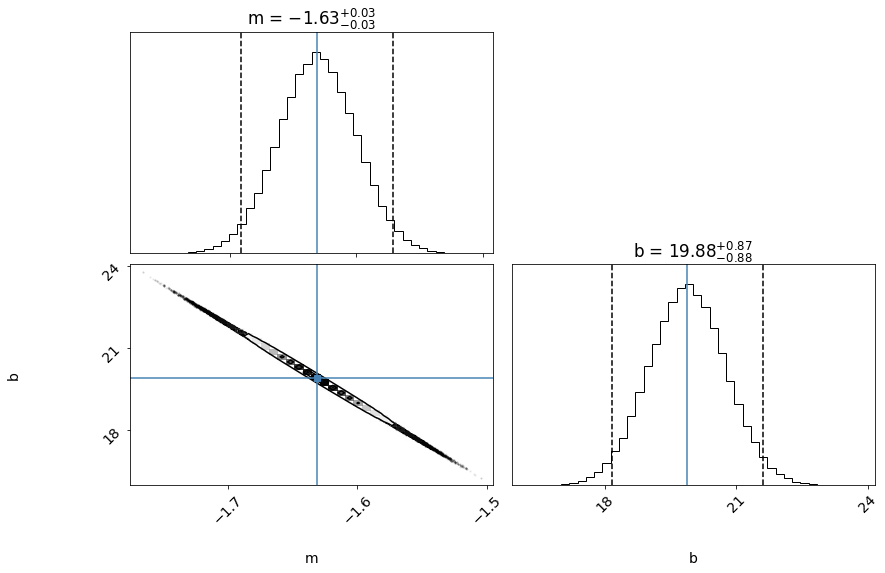

In [ ]:
subset=True if sampler_chain.shape[1] > 1e5 else False
lya_plot.walkers(sampler_chain, variables, variables_order, burnin, subset=subset)

make_corner_plot(samples, best, variables, variables_order, ndim)


#line_percentiles_to_store_dic, reconstructed_fluxes_dic = profile_plot(x_to_fit, y_to_fit, yerr_to_fit, None, samples, my_model, variables, variables_order, perform_error=perform_error, thin_out=1)


Best fit m, b = 
-1.6309874852512278 19.878170462768193
916.3527985773434 -452.8198130139997


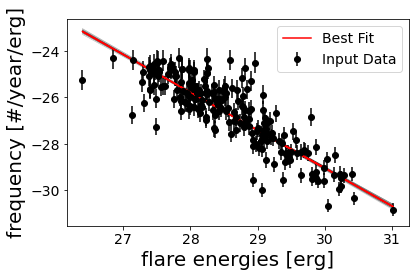

In [ ]:
plt.errorbar(x, y, yerr=yerr, fmt='ko', label='Input Data')
plt.xlabel('flare energies [erg]',fontsize=20)
plt.ylabel('frequency [#/year/erg]',fontsize=20)

print("Best fit m, b = ")
print(best[0,2], best[1,2])

for i in range(len(samples)):
  if i%10000 == 0:
    m_i = samples[i,0]
    b_i = samples[i,1]
    y_model_i = my_model(x_to_fit, None, [m_i,b_i], variables)
    plt.plot(x,y_model_i[0],color='k',alpha=0.1,linewidth=0.3)

y_model = my_model(x_to_fit,None, [best[0,2],best[1,2]], variables)
plt.plot(x,y_model[0],color='r',label='Best Fit')
plt.legend()
plt.tight_layout()

lnlikelihood = (-0.5*np.sum( (y-y_model[0])**2/yerr**2 + np.log(2*np.pi*yerr**2)))
bic = 2.* np.log(float(len(x))) - 2.* lnlikelihood
print(bic, lnlikelihood)

In [ ]:
# Store variables for use later in notebook

x_mcmc = x
y_mcmc = y
yerr_mcmc = yerr
y_model_mcmc = y_model[0]


beta_mcmc = 10**best[1,2]
alpha_mcmc = best[0,2]
error_approx_mcmc = mean([abs(best[0,2] - best[0,3]), abs(best[0,2] - best[0,1])])

### Compare the methods

In [ ]:
print('Linear fit:            ', abs(alpha_linear), '±', std_err)
print("D'Huys+ 2016 equations:", alpha, '±', results.power_law.sigma)
print('`powerlaw` package:    ', results.power_law.alpha, '±', results.power_law.sigma)
print('MCMC MLE:              ', abs(alpha_mcmc), '±', error_approx_mcmc)

Linear fit:             2.2571325388226797 ± 0.09496422563121784
D'Huys+ 2016 equations: 1.7474032619187616 ± 0.08869189262633945
`powerlaw` package:     1.7577838627787445 ± 0.08869189262633945
MCMC MLE:               1.6309874852512278 ± 0.03054988010403037



# **Histogram of chosen flare dates**


In [ ]:
import pandas as pd

flaredates = pd.read_csv('CPhLARE_dates.csv')     # Import data using pandas library

display(flaredates)       # Display the dataframe of the list of flares

,Date of Flare Peak
0,1/14/11
1,1/28/11
2,2/13/11
3,2/15/11
4,2/24/11
...,...
207,5/28/17
208,7/8/17
209,9/10/17
210,9/27/17


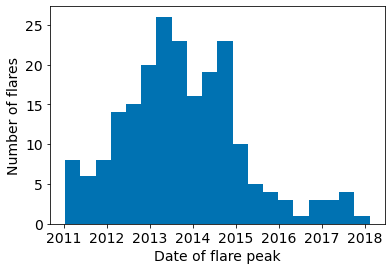

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# convert column to datetime
flaredates1 = pd.to_datetime(flaredates.iloc[:,0])

plt.hist(flaredates1, 20)
plt.xlabel('Date of flare peak')
plt.ylabel('Number of flares')
plt.show()

# **Supplemental Code**

## Computing the flare frequency from the given peak irradiance
### Comparison of fitting algorithms

In [ ]:
from numpy import arange
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor
import statsmodels.api as sm
from matplotlib import pyplot

In [ ]:
# reformat dataset
y = np.log(CPhLARE_data.iloc[:,1])    ## the x data for the linear regression is the energies ("I")
X = np.log(CPhLARE_data.iloc[:,0])     ## the y data for the linear regression is the irradiance ("E")

X = X.to_numpy()
y = y.to_numpy()

X = np.reshape(X, (-1,1))

>Linear 0.751 (0.151)
>Huber 0.747 (0.150)
>RANSAC 0.783 (0.155)
>TheilSen 0.747 (0.150)


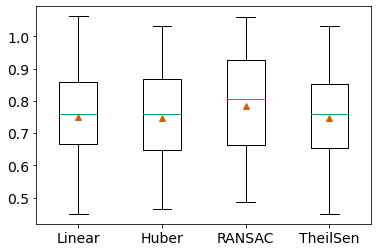

In [ ]:
# compare robust regression algorithms

# dictionary of model names and model objects
def get_models():
	models = dict()
	models['Linear'] = LinearRegression()
	models['Huber'] = HuberRegressor()
	models['RANSAC'] = RANSACRegressor()
	models['TheilSen'] = TheilSenRegressor()
	return models

# evaluate a model
def evalute_model(X, y, model, name):
	# define model evaluation method
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
	# force scores to be positive
	scores = absolute(scores)
	return scores

# retrieve models
models = get_models()
results = dict()
for name, model in models.items():
	# evaluate the model
	results[name] = evalute_model(X, y, model, name)
	# summarize progress
	print('>%s %.3f (%.3f)' % (name, mean(results[name]), std(results[name])))
# plot model performance for comparison
pyplot.boxplot(results.values(), labels=results.keys(), showmeans=True)
pyplot.show()



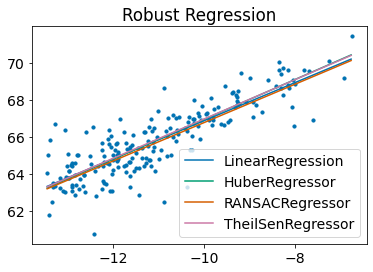

In [ ]:
# dictionary of model names and model objects
def get_models():
	models = list()
	models.append(LinearRegression())
	models.append(HuberRegressor())
	models.append(RANSACRegressor())
	models.append(TheilSenRegressor())
	return models
 
# plot the dataset and the model's line of best fit
def plot_best_fit(X, y, xaxis, model):
	# fit the model on all data
	model.fit(X, y)
	# calculate outputs for grid across the domain
	yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))
	# plot the line of best fit
	pyplot.plot(xaxis, yaxis, label=type(model).__name__)
 

# define a uniform grid across the input domain
xaxis = arange(X.min(), X.max(), 0.01)
for model in get_models():
	# plot the line of best fit
	plot_best_fit(X, y, xaxis, model)
# plot the dataset
pyplot.scatter(X, y, s = 10)
# show the plot
pyplot.title('Robust Regression')
pyplot.legend()
pyplot.show()

In [ ]:
# Compare alphas

model = LinearRegression()

reg = model.fit(X, y)

lr_EIslope = reg.coef_
lr_EIintercept = reg.intercept_
lr_IEalpha = 1/lr_EIslope
lr_IEbeta = np.exp(-lr_EIintercept/lr_EIslope)
#lr_EIbest_fit_line = lr_IEslope*X+lr_IEintercept

print("Linear regression slope:", lr_EIslope)
print("Linear regression alpha: ", lr_IEalpha, "+-", )

model = HuberRegressor()

reg = model.fit(X, y)

H_EIslope = reg.coef_
H_EIintercept = reg.intercept_
H_IEalpha = 1/H_EIslope
H_IEbeta = np.exp(-H_EIintercept/H_EIslope)
#H_IEbest_fit_line = H_IEslope*X+H_IEintercept

print("Huber regression slope", H_EIslope)
print("Huber regression alpha:", H_IEalpha)


model = RANSACRegressor()

reg = model.fit(X, y)

R_EIslope = model.estimator_.coef_
R_EIintercept = model.estimator_.intercept_
R_IEalpha = 1/R_EIslope
R_IEbeta = np.exp(-R_EIintercept/R_EIslope)
#R_IEbest_fit_line = R_IEslope*X+R_IEintercept

print("RANSAC regression slope:", R_EIslope)
print("RANSAC regression alpha:", R_IEalpha)

model = TheilSenRegressor()

reg = model.fit(X, y)

TS_EIslope = reg.coef_
TS_EIintercept = reg.intercept_
TS_IEalpha = 1/TS_EIslope
TS_IEbeta = np.exp(-TS_EIintercept/TS_EIslope)
#TS_IEbest_fit_line = TS_IEslope*X+TS_IEintercept

print("Theil Sen regression slope:", TS_EIslope)
print("Theil Sen regression alpha:", TS_IEalpha)

Linear regression slope: [-0.45936763]
Linear regression alpha:  [-2.17690567] +-
Huber regression slope [-0.47980934]
Huber regression alpha: [-2.08416116]
RANSAC regression slope: [-0.45947017]
RANSAC regression alpha: [-2.17641986]
Theil Sen regression slope: [-0.47237892]
Theil Sen regression alpha: [-2.1169446]


## Finding the power law relationshiop between total energy and flare frequency
### Comparison of fitting algorithms

In [ ]:
# reformat dataset
y = np.log(CPhLARE_data.iloc[:,1])    ## the x data for the linear regression is the energies ("E")
X = np.log(Efreq)      ## the y data for the linear regression is the irradiance ("I")

X = X.to_numpy()
y = y.to_numpy()

X = np.reshape(X, (-1,1))


>Linear 0.741 (0.149)
>Huber 0.737 (0.148)
>RANSAC 0.751 (0.146)
>TheilSen 0.743 (0.149)


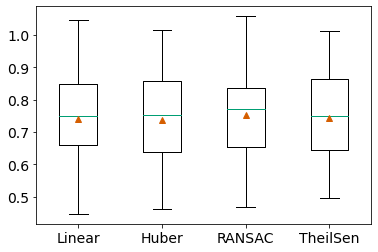

In [ ]:
# compare robust regression algorithms

# dictionary of model names and model objects
def get_models():
	models = dict()
	models['Linear'] = LinearRegression()
	models['Huber'] = HuberRegressor()
	models['RANSAC'] = RANSACRegressor()
	models['TheilSen'] = TheilSenRegressor()
	return models

# evaluate a model
def evalute_model(X, y, model, name):
	# define model evaluation method
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
	# force scores to be positive
	scores = absolute(scores)
	return scores

# retrieve models
models = get_models()
results = dict()
for name, model in models.items():
	# evaluate the model
	results[name] = evalute_model(X, y, model, name)
	# summarize progress
	print('>%s %.3f (%.3f)' % (name, mean(results[name]), std(results[name])))
# plot model performance for comparison
pyplot.boxplot(results.values(), labels=results.keys(), showmeans=True)
pyplot.show()

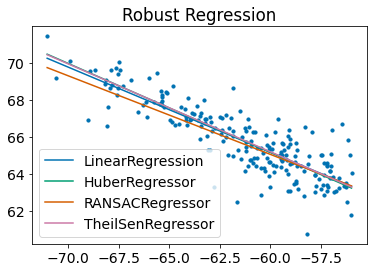

In [ ]:
# dictionary of model names and model objects
def get_models():
	models = list()
	models.append(LinearRegression())
	models.append(HuberRegressor())
	models.append(RANSACRegressor())
	models.append(TheilSenRegressor())
	return models
 
# plot the dataset and the model's line of best fit
def plot_best_fit(X, y, xaxis, model):
	# fit the model on all data
	model.fit(X, y)
	# calculate outputs for grid across the domain
	yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))
	# plot the line of best fit
	pyplot.plot(xaxis, yaxis, label=type(model).__name__)
 

# define a uniform grid across the input domain
xaxis = arange(X.min(), X.max(), 0.01)
for model in get_models():
	# plot the line of best fit
	plot_best_fit(X, y, xaxis, model)
# plot the dataset
pyplot.scatter(X, y, s = 10)
# show the plot
pyplot.title('Robust Regression')
pyplot.legend()
pyplot.show()

In [ ]:
# Compare alphas

model = LinearRegression()

reg = model.fit(X, y)

lr_slope = reg.coef_
lr_intercept = reg.intercept_
lr_alpha = 1/lr_slope
lr_beta = np.exp(-lr_intercept/lr_slope)

print("Linear regression slope:", lr_slope)
print("Linear regression alpha:", lr_alpha)

model = HuberRegressor()

reg = model.fit(X, y)

H_slope = reg.coef_
H_intercept = reg.intercept_
H_alpha = 1/H_slope
H_beta = np.exp(-H_intercept/H_slope)

print("Huber regression slope", H_slope)
print("Huber regression alpha:", H_alpha)

model = RANSACRegressor()

reg = model.fit(X, y)

R_slope = model.estimator_.coef_
R_intercept = model.estimator_.intercept_
R_alpha = 1/R_slope
R_beta = np.exp(-R_intercept/R_slope)

print("RANSAC regression slope:", R_slope)
print("RANSAC regression alpha:", R_alpha)


model = TheilSenRegressor()

reg = model.fit(X, y)

TS_slope = reg.coef_
TS_intercept = reg.intercept_
TS_alpha = 1/TS_slope
TS_beta = np.exp(-TS_intercept/TS_slope)

print("Theil Sen regression slope:", TS_slope)
print("Theil Sen regression alpha:", TS_alpha)


Linear regression slope: [-0.45936763]
Linear regression alpha: [-2.17690567]
Huber regression slope [-0.47980934]
Huber regression alpha: [-2.08416116]
RANSAC regression slope: [-0.60878175]
RANSAC regression alpha: [-1.64262479]
Theil Sen regression slope: [-0.47036204]
Theil Sen regression alpha: [-2.12602191]


# **Publication plots**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')
sns.set(font_scale=1.3)
sns.set(rc={'figure.figsize':(7, 5)})
fontsize = 14

## Peak irradiance (flare class) histogram



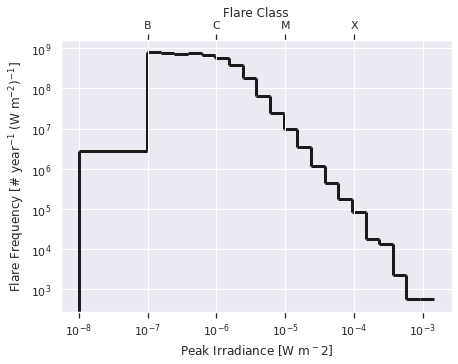

In [ ]:
num_flares_per_year_per_binwidth_shifted = np.roll(num_flares_per_year_per_binwidth, 1)
num_flares_per_year_per_binwidth_shifted[0] = num_flares_per_year_per_binwidth[0] - (num_flares_per_year_per_binwidth[1] - num_flares_per_year_per_binwidth[0])

fig, ax1 = plt.subplots(figsize=(7,5))
ax1.hlines(num_flares_per_year_per_binwidth, bin_edges[0:-1], bin_edges[1:], linewidth=3)
plt.vlines(bin_edges[0:-1], num_flares_per_year_per_binwidth, num_flares_per_year_per_binwidth_shifted, linewidth=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Peak Irradiance [W m${^-2}$]')
plt.ylabel('Flare Frequency [# year$^{-1}$ (W m$^{-2}$)$^{-1}$]')
ax1.minorticks_off()

new_tick_locations = np.array([1e-7, 1e-6, 1e-5, 1e-4])
ax2 = ax1.twiny()
ax2.set_xscale('log')
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(['B', 'C', 'M', 'X'])
ax2.set_xlabel('Flare Class')
ax2.minorticks_off()

plt.savefig('flare_class_histogram.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()


## FFD

In [ ]:
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"${0}0^{{{1}}}$".format(base, int(exponent))
    else:
        return float_str

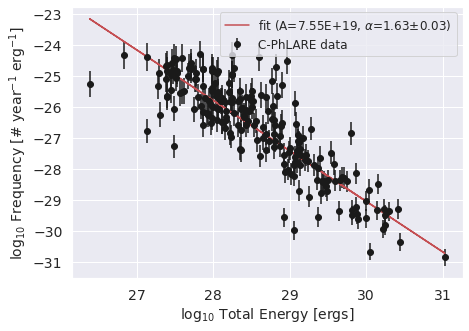

In [ ]:
## Plot the data with the best fit line on a log-log scale and inlcude a legend
fig, ax1 = plt.subplots(figsize=(7,5))
ax1.errorbar(x_mcmc, y_mcmc, yerr=yerr_mcmc, fmt='ko', label='C-PhLARE data')
ax1.plot(x_mcmc, y_model_mcmc, color='r', label=r'fit (A={:.2E}, $\alpha$={:0.2f}$\pm${:0.2f})'.format(beta_mcmc, -alpha_mcmc, error_approx_mcmc))

#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('log$_{10}$ Frequency [# year$^{-1}$ erg$^{-1}$]', fontsize=fontsize)
plt.xlabel('log$_{10}$ Total Energy [ergs]', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.legend(fontsize=fontsize-2) 

plt.savefig('ffd.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

## Peak irradiance vs energy

Peak vs Energy slope: 0.9730949865316758  +-  0.04208676908760155


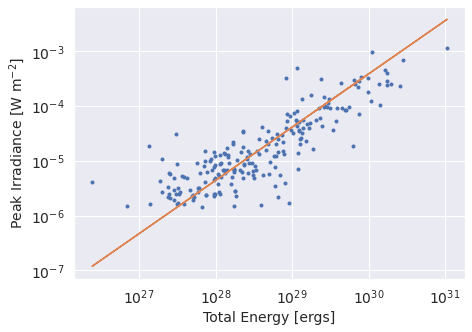

In [ ]:
print("Peak vs Energy slope:", lr_IEalpha, " +- ", lr_IEstd_err)
best_fit_line = lr_IEbeta*(CPhLARE_data.iloc[:,1]**lr_IEalpha)

fig, ax1 = plt.subplots(figsize=(7,5))
ax1.plot(CPhLARE_data.iloc[:,1], CPhLARE_data.iloc[:,0], '.', label='C-PhLARE data')
ax1.plot(CPhLARE_data.iloc[:,1], best_fit_line, label=r'fit (A={:.2E}, $\alpha$={:0.2f}$\pm${:0.2f})'.format(lr_IEbeta, lr_IEalpha, lr_IEstd_err))

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Peak Irradiance [W m$^{-2}$]', fontsize=fontsize)
plt.xlabel('Total Energy [ergs]', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.savefig('peak_irradiance_vs_energy.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

## Example of single flare

In [ ]:
df = pd.read_csv('single_flare_example_data.csv')
df = df.iloc[320:600]
df['longwave (W/m^2)'] *= 1e6
df.rename(columns={'longwave (W/m^2)': 'longwave (µW/m^2)'}, inplace=True)
df.rename(columns={'time (seconds since 2000-01-01 12:00:00)': 't'}, inplace=True)
df['t'] = (df['t'] - df['t'].iloc[0]) / 3600.
df.rename(columns={'t': 'time since start [hours]'}, inplace=True)
df.set_index('time since start [hours]', inplace=True)
df

,longwave (µW/m^2)
time since start [hours],
0.000000,1.465557
0.016667,1.444533
0.033333,1.415895
0.050000,1.396125
0.066667,1.403782
...,...
4.583333,0.536347
4.600000,0.516227
4.616667,0.509219


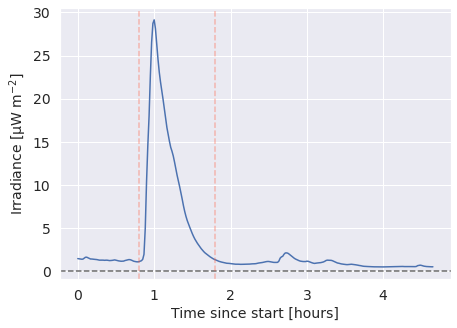

In [ ]:
fig, ax1 = plt.subplots(figsize=(7,5))
ax1.plot(df)
plt.ylabel('Irradiance [µW m$^{-2}$]', fontsize=fontsize)
plt.xlabel('Time since start [hours]', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
x0, x1 = ax1.get_xlim()
plt.axhline(y=0.13e-5, linestyle='dashed', color='dimgrey')
plt.axvline(x=0.8, linestyle='dashed', color='tomato', alpha=0.4)
plt.axvline(x=1.8, linestyle='dashed', color='tomato', alpha=0.4)

plt.savefig('example_light_curve.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.2)
